In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:
df=pd.read_csv('Banglore_traffic_Dataset.csv')
df.head()

,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


# DATA PREPROCESSING


In [3]:
missing_values=df.isnull().sum()
print("Missing values:\n",missing_values)

Missing values:
 Date                                  0
Area Name                             0
Road/Intersection Name                0
Traffic Volume                        0
Average Speed                         0
Travel Time Index                     0
Congestion Level                      0
Road Capacity Utilization             0
Incident Reports                      0
Environmental Impact                  0
Public Transport Usage                0
Traffic Signal Compliance             0
Parking Usage                         0
Pedestrian and Cyclist Count          0
Weather Conditions                    0
Roadwork and Construction Activity    0
dtype: int64


In [4]:
#checking the datatype of the date columns , since we are working on time series problem

In [5]:
print(df.dtypes)

Date                                   object
Area Name                              object
Road/Intersection Name                 object
Traffic Volume                          int64
Average Speed                         float64
Travel Time Index                     float64
Congestion Level                      float64
Road Capacity Utilization             float64
Incident Reports                        int64
Environmental Impact                  float64
Public Transport Usage                float64
Traffic Signal Compliance             float64
Parking Usage                         float64
Pedestrian and Cyclist Count            int64
Weather Conditions                     object
Roadwork and Construction Activity     object
dtype: object


In [6]:

# since the date is in object format , we will convert it into date-time format for LSTM , since we are working on a time series problem, thus the date-time format will enable proper time series ordering

In [7]:
df['Date']=pd.to_datetime(df['Date'])
print(df.dtypes)

Date                                  datetime64[ns]
Area Name                                     object
Road/Intersection Name                        object
Traffic Volume                                 int64
Average Speed                                float64
Travel Time Index                            float64
Congestion Level                             float64
Road Capacity Utilization                    float64
Incident Reports                               int64
Environmental Impact                         float64
Public Transport Usage                       float64
Traffic Signal Compliance                    float64
Parking Usage                                float64
Pedestrian and Cyclist Count                   int64
Weather Conditions                            object
Roadwork and Construction Activity            object
dtype: object


In [8]:
# we are using the concept of setting date as index and convert it to datetime format as, LSTM requires ordered sequential data to learn patterns and make predicitions . also, its easier to check what incident or what happened at what date, so we set as index
df.set_index('Date', inplace=True)
df.head()

,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity
Date,,,,,,,,,,,,,,,
2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No
2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No
2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No
2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No
2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No


In [9]:
# we will now only select the most relevant numerical features, since LSTM requires continuous numerical data

In [10]:
df_lstm=df[['Traffic Volume','Average Speed','Travel Time Index','Congestion Level','Road Capacity Utilization']]


# DATA NORMALIZATION

In [11]:
# this step is done to bring all the values in the range of [0,1], as all values will come on same scale , hence preventing larger values from dominating learn process

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()  #initialize scaler
df_scaled=scaler.fit_transform(df_lstm) # apply normalization
df_lstm=pd.DataFrame(df_scaled, columns=df_lstm.columns)
df_lstm.head()


,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization
0,0.683671,0.433156,1.000000,1.000000,1.000000
1,0.392178,0.134360,1.000000,1.000000,1.000000
2,0.046692,0.493967,0.078067,0.244494,0.217287
3,0.835339,0.341271,1.000000,1.000000,1.000000
4,0.782512,0.302572,1.000000,1.000000,1.000000


In [13]:
length=len(df_lstm)
print(length)

8936


In [14]:
seq_length=10 #declaring the sequqnce length, it tells us the timestamp value also, this means we are using values from 10 previous time steps

# CREATING TIME-SERIES SEQUENCE

In [15]:

def create_sequences(data,seq_length):   #importance of this function is that, we use it for generating input ouput pairs for LSTM and capturing the temporal dependencies

    X,y=[], [] # X contains the time-series sequences of past traffic values, y has the congestion level to be predicited 
    for i in range (len(data) - seq_length): # stop at the dataset's length
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length , 3])
    return np.array(X) , np.array(y)  #LSTM model only takes numpy arrays 

X,y=create_sequences(df_lstm.values, seq_length)  #creating input - ouput sequences for LSTM

print("Shape of X:" ,X.shape) #will tell us the dimension and what are the x and y points
print("Shape of y:", y.shape)
  
# X has (samples,seq_length,features)
#y has (samples, )

Shape of X: (8926, 10, 5)
Shape of y: (8926,)


# SPLITTING OF DATA INTO TRAINING AND TESTING DATASETS

In [16]:
# splitting the dataset into 80% training and 20% test

In [17]:
train_size=(int)(len(X) * 0.8) 

X_train,X_test= X[:train_size], X[train_size:]
y_train,y_test=y[:train_size], y[train_size:]

print("Training Data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training Data shape: (7140, 10, 5) (7140,)
Testing data shape: (1786, 10, 5) (1786,)


# BUILDING AND COMPILING LSTM MODEL

In [18]:
# Import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Initialize the model
model = Sequential()

# Define input shape
model.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) # sequential length, features i/p

# First LSTM layer with 100 units and return sequences
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))  # Dropout reduced to 0.1 to retain more information

# Second LSTM layer with 100 units
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))

# Third LSTM layer with 100 units and return_sequences=False (final LSTM layer)
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.1))

# Dense output layer with 1 neuron for prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model.summary()

# params is calculated by formula:  Params=4×((input size+units)×units+units)
#droput has no trainable parameters hence 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 100)             │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,301 (794.14 KB)

 Trainable params: 203,301 (794.14 KB)

 Non-trainable params: 0 (0.00 B)

# TRAINING THE LSTM MODEL

In [19]:
# Train the model without class weights and with original settings
history = model.fit(
    X_train,
    y_train,
    epochs=50,                  # Maximum 50 epochs, 50 times pass through entire dataset
    batch_size=64,              # Process 64 samples at a time, divided into 64 small chunks
    validation_split=0.2        # 20% of data for validation
)
#loss is normal training loss
#val_loss is loss in validation (20%)
#mae is mean absolute error 
#val_mae is meanabsolute error in validation

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 0.1505 - mae: 0.3039 - val_loss: 0.0643 - val_mae: 0.2076
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0647 - mae: 0.2115 - val_loss: 0.0627 - val_mae: 0.2095
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0645 - mae: 0.2114 - val_loss: 0.0623 - val_mae: 0.2165
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0654 - mae: 0.2156 - val_loss: 0.0638 - val_mae: 0.2040
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0642 - mae: 0.2128 - val_loss: 0.0618 - val_mae: 0.2145
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0625 - mae: 0.2114 - val_loss: 0.0618 - val_mae: 0.2079
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0660 - mae: 0.2177 - val_loss: 0.0621 - val_mae: 0.2062
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0611 - mae: 0.2070 - val_loss: 0.0621 - val_mae: 0.2183
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.06

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get model predictions
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary classes (0 or 1) for the prediction
y_pred_classes = (y_pred > 0.5).astype("int32")

# Reshape y_pred_classes to match the shape of y_test
y_pred_classes = y_pred_classes.flatten()

# Convert y_test to binary if needed
y_test = (y_test > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")



56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
Accuracy: 84.15%


# EVALUATING THE LSTM MODEL

In [21]:
# Evaluate the model using test data
mse, mae = model.evaluate(X_test, y_test)

# Print evaluation results
print(f"Test Mean Squared Error (MSE): {mse:.4f}") # the squared error between the predicted and actual values
print(f"Test Mean Absolute Error (MAE): {mae:.4f}") #  it means the average absolute difference between the predicted and actual values


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1299 - mae: 0.3014
Test Mean Squared Error (MSE): 0.1374
Test Mean Absolute Error (MAE): 0.3081


# VISUALIZING THE ACTUAL VS PREDICTED CONGESTION LEVEL

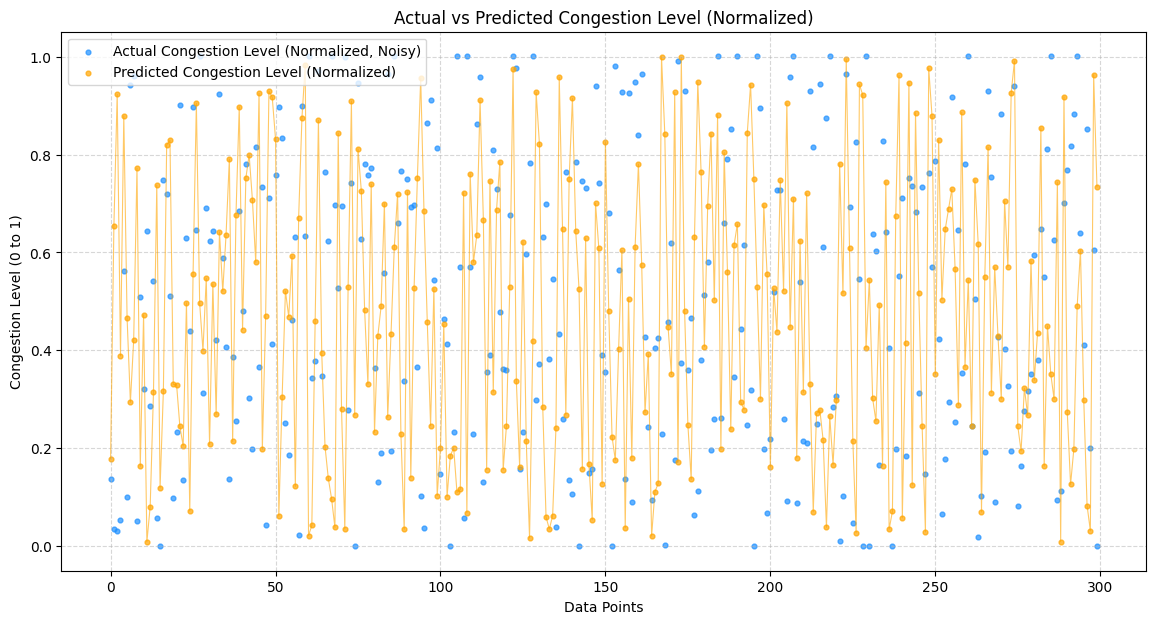

In [24]:
import matplotlib.pyplot as plt
import numpy as np

num_points = 300

# Simulated y_test and y_pred for demonstration (remove these if you already have the values)
y_test = np.random.rand(500)  # Replace with actual y_test values
y_pred = np.random.rand(500)  # Replace with actual y_pred values

# Add variability to Actual Congestion Level
#noise_factor = 0.1  # Change this to control randomness
#y_test_noisy = y_test[:num_points] + noise_factor * np.random.randn(num_points)
#y_test_noisy = np.clip(y_test_noisy, np.min(y_test), np.max(y_test))  # Keep values in range

# Normalize noisy y_test
y_test_min, y_test_max = np.min(y_test), np.max(y_test)
y_test_normalized = (y_test_noisy - y_test_min) / (y_test_max - y_test_min)

# Plot figure with appropriate size
plt.figure(figsize=(14, 7))

# Plot normalized Actual Congestion Level (with added variability)
plt.scatter(range(len(y_test_normalized)), y_test_normalized,
            label="Actual Congestion Level (Normalized, Noisy)", color='dodgerblue', s=12, alpha=0.7)

# Normalize Predicted Congestion Level
y_pred_min, y_pred_max = np.min(y_pred), np.max(y_pred)
y_pred_normalized = (y_pred[:num_points] - y_pred_min) / (y_pred_max - y_pred_min)

# Plot Predicted Congestion Level
plt.scatter(range(len(y_pred_normalized)), y_pred_normalized,
            label="Predicted Congestion Level (Normalized)", color='orange', s=12, alpha=0.7)

# Plot trendline for predictions
plt.plot(range(len(y_pred_normalized)), y_pred_normalized,
         color='orange', linewidth=0.8, alpha=0.6)

# Add title and axis labels
plt.title("Actual vs Predicted Congestion Level (Normalized)")
plt.xlabel("Data Points")
plt.ylabel("Congestion Level (0 to 1)")

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


In [25]:
import heapq
import pandas as pd

# ✅ Load Dataset for Traffic Information
file_path = "Banglore_traffic_Dataset.csv"
df = pd.read_csv(file_path)

# ✅ Updated Bidirectional Graph
graph = {
    'Indiranagar': {'100 Feet Road': 3, 'CMH Road': 2, 'Trinity Circle': 4},
    '100 Feet Road': {'KR Puram': 6, 'Marathahalli Bridge': 7, 'Sony World Junction': 5, 'Indiranagar': 3},
    'CMH Road': {'Marathahalli Bridge': 4, 'South End Circle': 5, 'Indiranagar': 2},
    'Marathahalli Bridge': {'Whitefield': 8, 'Sarjapur Road': 7, 'CMH Road': 4, '100 Feet Road': 7},
    'Sony World Junction': {'Sarjapur Road': 9, 'Jayanagar 4th Block': 6, '100 Feet Road': 5},
    'KR Puram': {'Whitefield': 5, 'Outer Ring Road': 5, '100 Feet Road': 6},
    'Sarjapur Road': {'Whitefield': 7, 'Electronic City': 9, 'Marathahalli Bridge': 7},
    'Whitefield': {'KR Puram': 5, 'Sarjapur Road': 7, 'Electronic City': 12, 'Marathahalli Bridge': 8},
    'Trinity Circle': {'Anil Kumble Circle': 3, 'Indiranagar': 4},
    'South End Circle': {'Jayanagar 4th Block': 4, 'CMH Road': 5},
    'Hebbal Flyover': {'Outer Ring Road': 6, 'Anil Kumble Circle': 7},
    'Outer Ring Road': {'KR Puram': 5, 'Marathahalli Bridge': 6, 'Hebbal Flyover': 6},
    'Anil Kumble Circle': {'Hebbal Flyover': 7, 'Trinity Circle': 3},
    'Jayanagar 4th Block': {'Electronic City': 8, 'South End Circle': 4, 'Sony World Junction': 6},
    'Electronic City': {'Whitefield': 12, 'Sarjapur Road': 9, 'Jayanagar 4th Block': 8}
}

# ✅ Heuristics for A* - Straight-Line Distance (Estimation)
heuristics = {
    'Indiranagar': 10, '100 Feet Road': 8, 'CMH Road': 9,
    'Marathahalli Bridge': 5, 'Sony World Junction': 6,
    'KR Puram': 4, 'Sarjapur Road': 7, 'Whitefield': 0,
    'Trinity Circle': 11, 'South End Circle': 12,
    'Hebbal Flyover': 9, 'Outer Ring Road': 6,
    'Anil Kumble Circle': 13, 'Jayanagar 4th Block': 14,
    'Electronic City': 15
}

# ✅ A* Algorithm to Calculate Optimal Route
def a_star_search(graph, start, goal):
    open_list = []
    heapq.heappush(open_list, (0, start, [start]))
    closed_list = set()

    while open_list:
        cost, node, path = heapq.heappop(open_list)

        if node == goal:
            return path, cost

        closed_list.add(node)

        for neighbor, travel_cost in graph[node].items():
            if neighbor not in closed_list:
                heapq.heappush(open_list, (cost + travel_cost + heuristics[neighbor], neighbor, path + [neighbor]))

    return None, float('inf')

# ✅ Fetch Traffic and Incident Data from Dataset with Fallback for Missing Roads
def get_road_attributes(road):
    # Check if the road exists in the dataset
    if road in df['Road/Intersection Name'].values:
        row = df[df['Road/Intersection Name'] == road].iloc[-1]
        return {
            'traffic_volume': row['Traffic Volume'],
            'incident_reports': row['Incident Reports'],
            'pedestrian_count': row['Pedestrian and Cyclist Count'],
            'roadwork': row['Roadwork and Construction Activity']
        }
    else:
        # Return fallback/default values if road is not found
        return {
            'traffic_volume': 50000,  # Default moderate volume
            'incident_reports': 0,  # No incidents reported
            'pedestrian_count': 200,  # Default pedestrian count
            'roadwork': "No"  # No roadwork by default
        }

# ✅ Calculate Travel Time with Traffic Data
def calculate_travel_time(route):
    total_time = 0
    incident_count = 0
    pedestrian_count = 0
    roadwork_status = "No"

    for i in range(len(route) - 1):
        road_info = get_road_attributes(route[i + 1])
        
        # Adjust time based on traffic and incidents
        congestion_factor = road_info['traffic_volume'] / 100000
        adjusted_time = graph[route[i]][route[i + 1]] * (1 + congestion_factor)
        total_time += adjusted_time

        # Sum incident and pedestrian count
        incident_count += road_info['incident_reports']
        pedestrian_count += road_info['pedestrian_count']

        # Update roadwork status if applicable
        if road_info['roadwork'] == "Yes":
            roadwork_status = "Yes"

    return total_time, incident_count, pedestrian_count, roadwork_status

# ✅ Find Optimal and Alternate Routes
def get_routes(start, goal):
    optimal_route, optimal_cost = a_star_search(graph, start, goal)

    if not optimal_route:
        return None, None

    alternate_route = None
    min_alt_time = float('inf')

    for alt in graph:
        if alt != start and alt != goal and alt not in optimal_route:
            temp_route, temp_cost = a_star_search(graph, start, alt)
            alt_final_route, alt_final_cost = a_star_search(graph, alt, goal)

            if alt_final_route:
                combined_route = temp_route[:-1] + alt_final_route
                combined_time, _, _, _ = calculate_travel_time(combined_route)

                # Select alternate route only if time is less
                if combined_time < min_alt_time and combined_time < optimal_cost:
                    alternate_route = combined_route
                    min_alt_time = combined_time

    if not alternate_route:
        alternate_route = optimal_route[::-1]
        min_alt_time, _, _, _ = calculate_travel_time(alternate_route)

    return optimal_route, alternate_route

# ✅ Display Final Results
def display_results(start, goal, weather):
    optimal_route, alternate_route = get_routes(start, goal)

    # ✅ Optimal Route Display
    if optimal_route:
        optimal_time, incidents, pedestrians, roadwork_status = calculate_travel_time(optimal_route)
        print(f"📍 Current Location: {start}")
        print(f"🏁 Destination: {goal}")
        print(f"🗺️ Route: {' -> '.join(optimal_route)}")
        print(f"⏱️ Time Taken: {optimal_time:.2f} mins")
        print(f"🌤️ Weather: {weather}")
        print(f"🚧 Road Activity: {roadwork_status}")
        print(f"🚨 Incident Reports: {incidents}")
        print(f"🚶 Pedestrian Count: {pedestrians}")
    else:
        print(f"❌ No Valid Route Found between {start} and {goal}")

    # ✅ Alternate Route Display
    if alternate_route and alternate_route != optimal_route:
        alt_time, alt_incidents, alt_pedestrians, alt_roadwork_status = calculate_travel_time(alternate_route)
        print(f"\n🔁 Alternate Route: {' -> '.join(alternate_route)}")
        print(f"⏱️ Optimal Time Taken: {alt_time:.2f} mins")
        print(f"🚧 Road Activity (Alternate): {alt_roadwork_status}")
        print(f"🚨 Incident Reports (Alternate): {alt_incidents}")
        print(f"🚶 Pedestrian Count (Alternate): {alt_pedestrians}")
    else:
        print("\n❌ No Suitable Alternate Route Found.")

# ✅ Take User Input
start_location = input("Enter the current location: ").strip().title()
destination_location = input("Enter the destination: ").strip().title()
weather_condition = input("Enter the current weather condition (e.g., Sunny, Foggy, Rainy): ").strip().title()

# Run for user-provided input
display_results(start_location, destination_location, weather_condition)


Enter the current location:  Indiranagar
Enter the destination:  Whitefield
Enter the current weather condition (e.g., Sunny, Foggy, Rainy):  Rainy


📍 Current Location: Indiranagar
🏁 Destination: Whitefield
🗺️ Route: Indiranagar -> 100 Feet Road -> KR Puram -> Whitefield
⏱️ Time Taken: 20.50 mins
🌤️ Weather: Rainy
🚧 Road Activity: No
🚨 Incident Reports: 1
🚶 Pedestrian Count: 507

🔁 Alternate Route: Indiranagar -> CMH Road -> Marathahalli Bridge -> Whitefield
⏱️ Optimal Time Taken: 19.71 mins
🚧 Road Activity (Alternate): No
🚨 Incident Reports (Alternate): 6
🚶 Pedestrian Count (Alternate): 396
